In [61]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve
import lib

Local Polynomial Approximation
-------------------------------
Set the parameters

In [62]:
# maximum degree of polynomial used for fitting
N = 2

# filter size
M = 51

# large M, small N -> a lot of bias when frequency increases
# N = 2
# M = 51

# large M, large N -> smaller bias than before, but a lot of variance in smooth regions
# N = 7
# M = 51

# small M, small N -> smaller bias everywhere, higher variance
# N = 2
# M = 5

# M small, M = N,  -> smaller bias than before, higher variance than before
# N = 5
# N = M

Generate synthetic signal signal

In [63]:
LENGHT = 1000

ty = np.linspace(0, 1, LENGHT)
y = np.sin(2 / (ty + 0.05))

#  noise standard deviation
sigma = 0.1

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)

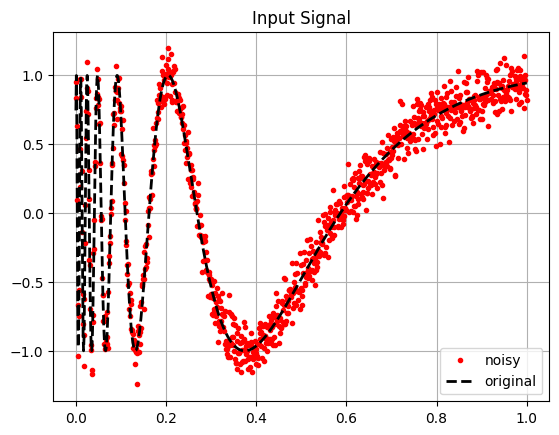

In [64]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal');

Define the matrix T containing the polynomials sampled over the window


In [65]:
t = np.arange(M)
T = np.stack([t**i for i in range(N+1)], axis=-1)
T.shape

(51, 3)

Look at the matrix T, the columns correspond to polynomials sampled over the interval [0,1]


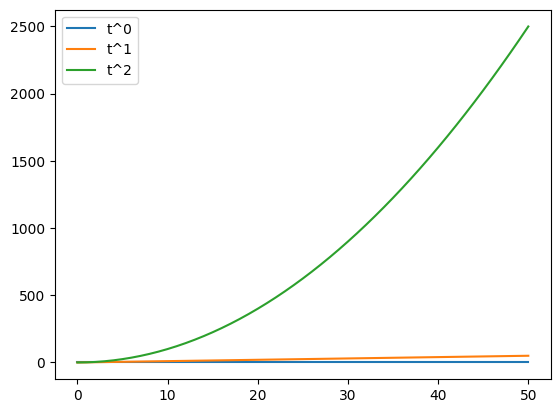

In [66]:
plt.figure()
leg = []
for l in range(N+1):
    plt.plot(t, T[:, l])
    leg.append(f't^{l:d}')
plt.legend(leg);

Construct the LPA kernel

In [67]:
# comput the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(T)

# select the central row of W2Qtilde
row = M // 2

# compute the kernel
g = Q @ Q[row]

# flipping, since it is used in convolution
g = np.flip(g)

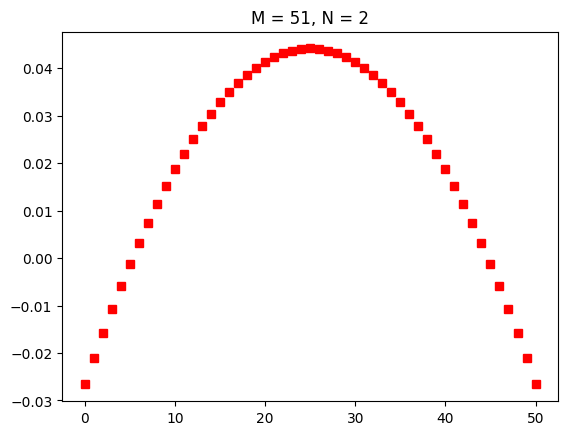

In [68]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'M = {M:d}, N = {N:d}');

Filtering

In [69]:
shat = np.convolve(s, g, mode='same')
shat.shape

(1000,)

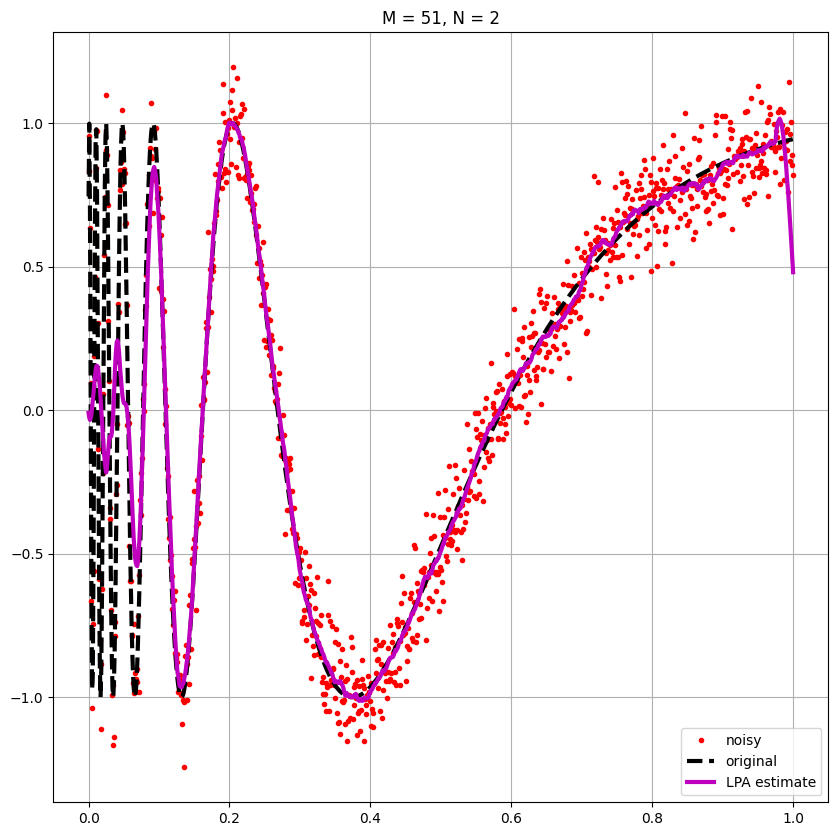

In [70]:
plt.figure(figsize=(10,10))
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}');

Weighted LPA
--------------
Set the parameters

In [71]:
# maximum degree of polynomial used for fitting
N = 1

# filter size
M = 53

# half filter size
HFS = int((M-1)/2)

# set the weights. Here weights simply define the window size
w = np.zeros(M)

# centered kernel
wc = w.copy()
wc[int(HFS/2):-int(HFS/2)] = 1

# left kernel
wl = w.copy()
wl[:HFS+1] = 1

# right kernel
wr = w.copy()
wr[-HFS-1:] = 1

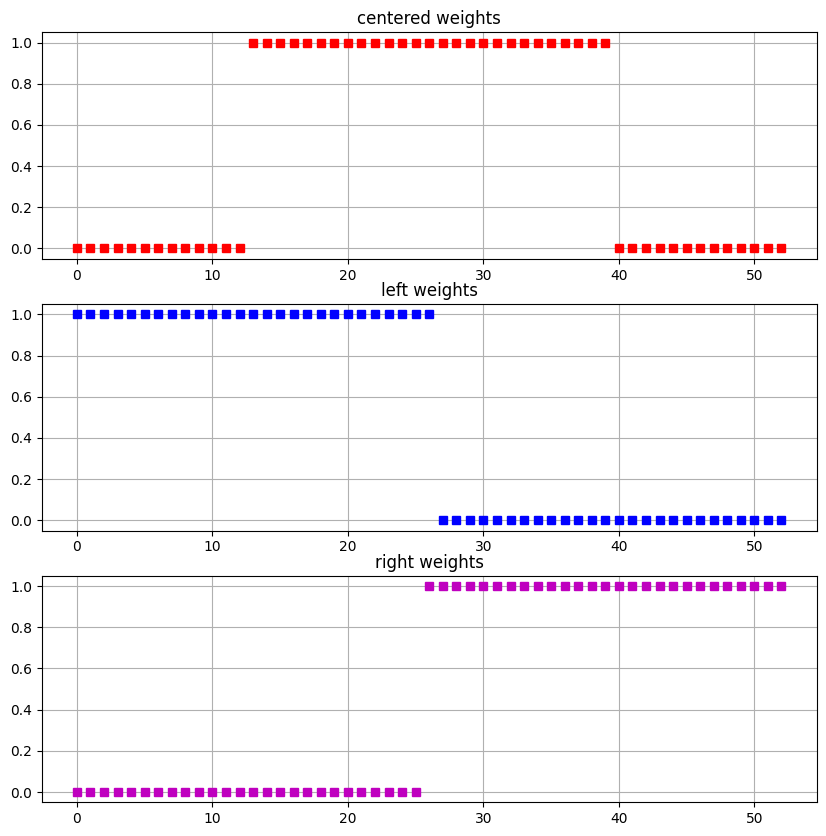

In [72]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
ax[0].plot(wc, 'rs', linewidth=3)
ax[0].set_title('centered weights')
ax[0].grid()
ax[1].plot(wl, 'bs', linewidth=3)
ax[1].set_title('left weights')
ax[1].grid()
ax[2].plot(wr, 'ms', linewidth=3)
ax[2].set_title('right weights')
ax[2].grid();

Build the weight matrix

In [73]:
# select a single weight to be used in what follows
w = wr

# generate the inverse of weights
winv = 1 / w

# set to zero weights that are inf
# winv...
winv[winv == np.inf] = 0

# define the weight matrix
W = np.diag(w)
Winv = np.diag(winv)
W.shape, Winv.shape

/var/folders/29/68f5_tk131x7cx496z5c3sxr0000gn/T/ipykernel_37348/2523824492.py:5: RuntimeWarning: divide by zero encountered in divide
  winv = 1 / w


((53, 53), (53, 53))

Generate synthetic signal signal

In [74]:
LENGHT = 1000

# clean signal
ty = np.linspace(0, 1, LENGHT)
y =  8*ty**2 - 2*ty + 2;
y[LENGHT//2 : LENGHT] = y[LENGHT//2 : LENGHT] + 7;

#  noise standard deviation
sigma = 0.2

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)

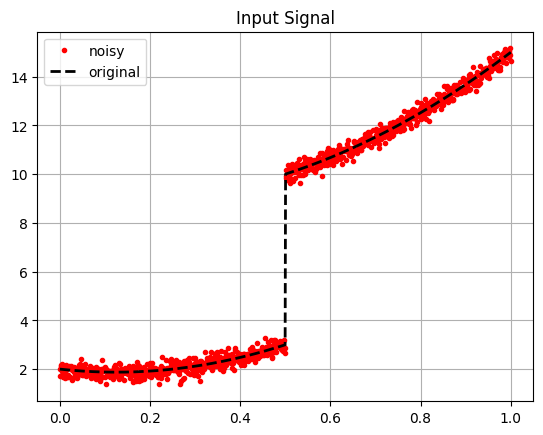

In [75]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal');

Define the matrix T containing the polynomials sampled over the window

In [76]:
t = np.arange(M)
T = np.stack([t**n for n in range(N+1)], axis=-1)
T.shape

(53, 2)

Construct the LPA kernel

In [77]:
# comput the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(T)

# flipping, since it is used in convolution
g = np.flip((Q @ np.linalg.inv(Q.T @ W ** 2 @ Q) @ Q.T @ W ** 2)[row])
g.shape

(53,)

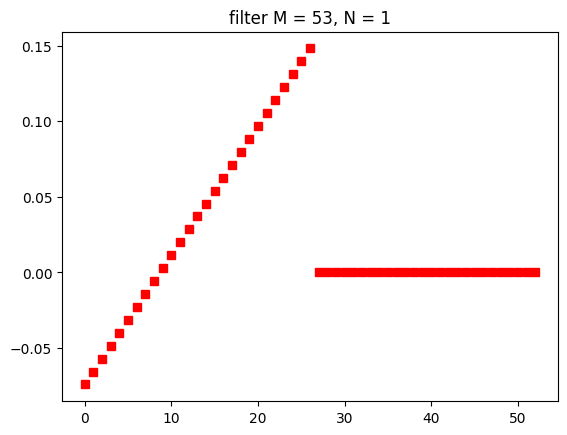

In [78]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'filter M = {M:d}, N = {N:d}');

Filtering


In [79]:
shat = np.convolve(s, g, mode='same')

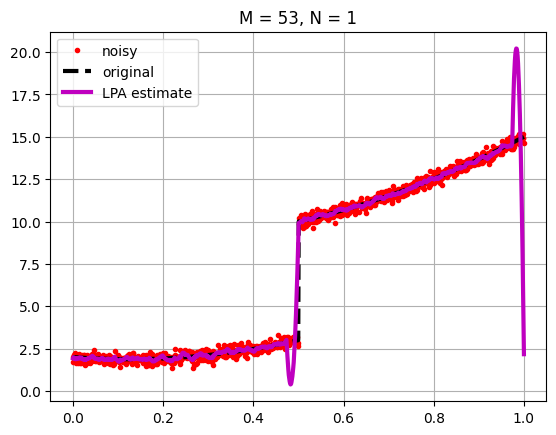

In [80]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}');

Modify the code to use the central, left and right kernels